# Introduction to the Monte Carlo method

----

Start by defining the [Gibbs (or Boltzmann) distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution):
$$P(\alpha) = e^{-E(\alpha)/kT}$$
this expression, defines the probability of observing a particular configuration of spins, $\alpha$. 
As you can see, the probability of $\alpha$ decays exponentially with increasing energy of $\alpha$, $E(\alpha)$,
where $k$ is the Boltzmann constant, $k = 1.38064852 \times 10^{-23} J/K$
and $T$ is the temperature in Kelvin. 

## What defines the energy of a configuration of spins? 
Given a configuration of spins (e.g., $\uparrow\downarrow\downarrow\uparrow\downarrow$) we can define the energy using what is referred to as an Ising Hamiltonian:
$$ \hat{H}' = \frac{\hat{H}}{k} = -\frac{J}{k}\sum_{<ij>} s_is_j,$$
where, $s_i=1$ if the $i^{th}$ spin is `up` and $s_i=-1$ if it is `down`, and the brackets $<ij>$ indicate a sum over spins that are connected,
and $J$ is a constant that determines the energy scale. 
The energy here has been divided by the Boltzmann constant to yield units of temperature. 
Let's consider the following case, which has the sites connected in a single 1D line:
$$\alpha = \uparrow-\downarrow-\downarrow-\uparrow-\downarrow.$$ 
What is the energy of such a configuration?
$$ E(\alpha)' = J/k(-1 + 1 - 1 - 1) = \frac{E(\alpha)}{k} = -2J/k$$

## P1: Write a class that defines a spin configuration

In [1]:
class SpinConfig :
    def __init__(self, *args) :
        """
        Initialize a spin configuration.
        Parameters:
        spins: a list of 1's and -1's that represent the spins.
        OR
        value: a number representing the spin state, with 1's being spin up and 0's being spin downs.
        length: a number representing the number of spinning things.
        """
        if len(args) == 1 :
            spins = args[0]
            assert(all(s == 1 or s == -1 for s in spins))
            self.__spins = list(spins)
            self.__len = len(spins)
        elif len(args) == 2 :
            assert(type(args[0]) is int)
            value = args[0]
            length = args[1]
            self.__spins = []
            for i in range(length) :
                self.__spins.insert(0, 2 * (value & 1) - 1)
                value = value >> 1
            self.__len = length
    def __len__(self) :
        return self.__len
    def __str__(self) :
        return str(self.__spins)
    def __getitem__(self, index) :
        return self.__spins[index]
    def __setitem__(self, index, value) :
        assert(value == 1 or value == -1)
        self.__spins[index] = value
        return value
    def __iter__(self) :
        return iter(self.__spins)
    

## P2: Write a class that defines the 1D hamiltonian, containing a function that computes the energy of a configuration

In [2]:
boltzmann_k = 1.38064852e-23
boltzmann_k_hart = 3.167e-6
class Hamiltonian :
    def __init__(self, coupling, magnet, spinconf) :
        self.__spins = spinconf
        self.__coupling = coupling
        self.__magnet = magnet
    def getspins(self) :
        return self.__spins
    def getcoupling(self) :
        return self.__coupling
    def getmagnet(self) :
        return self.__magnet
    def findenergy(self) :
        return -self.__coupling * sum(self.__spins[i - 1] * self.__spins[i] 
                                                   for i in range(len(self.__spins))) + \
            self.__magnet * sum(self.__spins)
    def findtemp(self) :
        return self.findenergy() / boltzmann_k
    

## Properties
For any fixed state, $\alpha$, the `magnetization` ($M$) is proportional to the _excess_ number of spins pointing up or down while the energy is given by the
Hamiltonian:
$$M(\alpha) = N_{\text{up}}(\alpha) - N_{\text{down}}(\alpha).$$
As a dynamical, fluctuating system, each time you measure the magnetization, the system might be in a different state ($\alpha$) and so you'll get a different number!
However, we already know what the probability of measuring any particular $\alpha$ is, so in order to compute the average magnetization, $\left<M\right>$, we just need to multiply the magnetization of each possible configuration times the probability of it being measured, and then add them all up!
$$ \left<M\right> = \sum_\alpha M(\alpha)P(\alpha).$$
In fact, any average value can be obtained by adding up the value of an individual configuration multiplied by it's probability:
$$ \left<E\right> = \sum_\alpha E(\alpha)P(\alpha).$$

This means that to obtain any average value (also known as an `expectation value`) computationally, we must compute the both the value and probability of all possible configurations. This becomes extremely expensive as the number of spins ($N$) increases. 

## P3: Write a function that computes the magnetization of a spin configuration

In [3]:
def magnetization(spinconf) :
    return len(list(filter(lambda s: s == 1, spinconf))) - len(list(filter(lambda s: s == -1, spinconf)))

## Q2: How many configurations are possible for:

(a) N=10?

In [4]:
def numconf(sites) :
    if type(sites) is int :
        return 2 ** sites
    else :
        return 2 ** len(sites)
numconf(10)

1024

(b) N=100?

In [5]:
numconf(100)

1267650600228229401496703205376

(c) N=1000?

## Q3: What is the energy for (++-+---+--+)?

In [6]:
config = SpinConfig([1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1])
ham = Hamiltonian(2, 1.1, config)
ham.findenergy()

0.8999999999999999

Find the partition function with a given magnetization and coupling constant, at a given temperature, for a given number of positions.

In [7]:
import math
def partition(positions, coupling, magnet, temp = 298.15) :
    return sum(math.exp(-Hamiltonian(coupling, magnet, SpinConfig(s, positions)).findenergy() / 
                        temp) for s in range(numconf(positions)))

In [8]:
partition(10, 2, 1.1)

1024.3010643479497

Find the average value for a given function of spin configurations.

In [9]:
def average_value(avg_func, positions, coupling, magnet, temp = 298.15, *args, **kwargs) :
    """
    avg_func expects a spin configuration. args and kwargs are passed in as well.
    """
    return sum(avg_func(SpinConfig(s, positions), *args, **kwargs) * 
               math.exp(-Hamiltonian(coupling, magnet, SpinConfig(s, positions)).findenergy() / 
                        temp) for s in range(numconf(positions))) / \
        partition(positions, coupling, magnet, temp)

Average energy

In [10]:
average_value(lambda sp : Hamiltonian(2, 1.1, sp).findenergy(), 10, 2, 1.1)

-0.17556610117657653

Average magnetization

In [11]:
average_value(magnetization, 10, 2, 1.1)

-0.03739231416188296

Standard deviation for the energy

In [12]:
math.sqrt(average_value(lambda sp: (Hamiltonian(2, 1.1, sp).findenergy()) ** 2, 10, 2, 1.1) - \
    average_value(lambda sp: Hamiltonian(2, 1.1, sp).findenergy(), 10, 2, 1.1) ** 2)

7.252007033869644

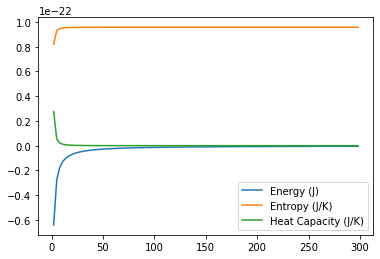

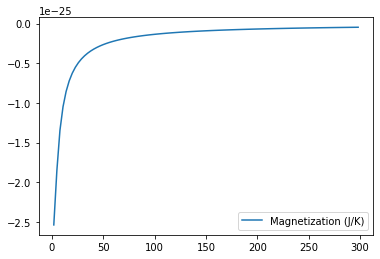

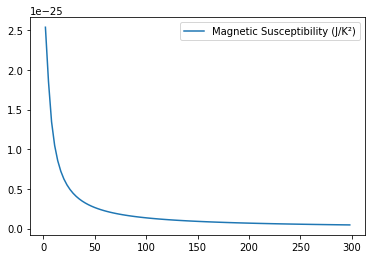

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures

J = -1
M = 0.1
N = 10

xs = np.linspace(2, 298.15, 100)
ex = concurrent.futures.ThreadPoolExecutor(4)
ener = list(map(lambda x: average_value(lambda sp: Hamiltonian(J * boltzmann_k,
                                                                  M * boltzmann_k, sp).findenergy(), N, J, M, x), xs))
mag = list(map(lambda x: M * boltzmann_k * average_value(magnetization, N, J, M, x), xs))
heat = list(map(lambda x: (average_value(lambda sp: (Hamiltonian(J * boltzmann_k, M * boltzmann_k, 
                                                                    sp).findenergy()) ** 2, 
                                                  N, J, M, x) - 
                                    average_value(lambda sp: Hamiltonian(J * boltzmann_k,
                                                                         M * boltzmann_k, sp).findenergy(),
                                                  N, J, M, x)
                                    ** 2) / (boltzmann_k * x ** 2), xs))
ms = list(map(lambda x: (average_value(lambda sp: (M * boltzmann_k * magnetization(sp)) ** 2, N, J, 
                                          M, x) - 
              (M * boltzmann_k * average_value(magnetization, N, J, M, x)) ** 2) / (boltzmann_k * x), xs))

ent = list(map(lambda x: boltzmann_k * (math.log(partition(N, M, J, x)) + 
                                                    average_value(lambda sp: Hamiltonian(J * boltzmann_k, 
                                                                                        M * boltzmann_k,
                                                                                        sp).findenergy(), 
                                                                 N, J, M, x) / (boltzmann_k * x)), xs))

ex.shutdown()

plt.figure()
plt.plot(xs, ener, label="Energy (J)")
plt.plot(xs, ent, label="Entropy (J/K)")
plt.plot(xs, heat, label="Heat Capacity (J/K)")
plt.legend()
plt.figure()
plt.plot(xs, mag, label="Magnetization (J)")
plt.legend()
plt.figure()
plt.plot(xs, ms, label="Magnetic Susceptibility (J/K)")
plt.legend()
plt.show()